In [ ]:
!mkdir ~\.kaggle

In [ ]:
!cd ~\.kaggle && ls

In [ ]:
!kaggle competitions download -c petfinder-pawpularity-score

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
#import af libaries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2

from PIL import Image
import imagehash
import imageio

In [4]:
#test is not working i need to have a look at the download again
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Amount of tranning's data: " + str(len(train)))
print("Amount of test data: " + str(len(test)))

Amount of tranning's data: 9912
Amount of test data: 8


In [5]:
#Loading images
def get_train_file_path(image_id):
    return r"C:\Users\tobia\Github\PetFinder\train\{}.jpg".format(image_id)

def get_test_file_path(image_id):
    return r"C:\Users\tobia\Github\PetFinder\test\{}.jpg".format(image_id)

train['file_path'] = train['Id'].apply(get_train_file_path)
test['file_path'] = test['Id'].apply(get_test_file_path)
# Shows the first 5, change the paramter for more
display(train.head())
display(test.head())

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                           file_path  
0  C:\Users\tobia\Github\PetFinder\train\0007de18...  
1  C:\Users\tobia\Github\PetFinder\train\0009c66b...  
2  C:\Users\tobia\Github\PetFinder\train\0013fd99...  
3  C:\Users\tobia\Github\PetFinder\train\0018df34...  
4  C:\Users\tobia\Github\PetFinder\train\001dc955...

Id  Subject Focus  Eyes  Face  Near  Action  \
0  4128bae22183829d2b5fea10effdb0c3              1     0     1     0       0   
1  43a2262d7738e3d420d453815151079e              0     1     0     0       0   
2  4e429cead1848a298432a0acad014c9d              0     0     0     1       0   
3  80bc3ccafcc51b66303c2c263aa38486              1     0     1     0       0   
4  8f49844c382931444e68dffbe20228f4              1     1     1     0       1   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          1      1        0      0          1     0     1   
1          0      1        1      0          0     0     0   
2          1      1        1      0          1     1     1   
3          0      0        0      0          0     1     0   
4          1      0        1      0          1     1     0   

                                           file_path  
0  C:\Users\tobia\Github\PetFinder\test\4128bae22...  
1  C:\Users\tobia\Github\PetFinder\test\43a2262d7...  
2  C:\Users\tobia\Github\PetFinder\test\4e429cead...  
3  C:\Users\tobia\Github\PetFinder\test\80bc3ccaf...  
4  C:\Users\tobia\Github\PetFinder\test\8f49844c3...

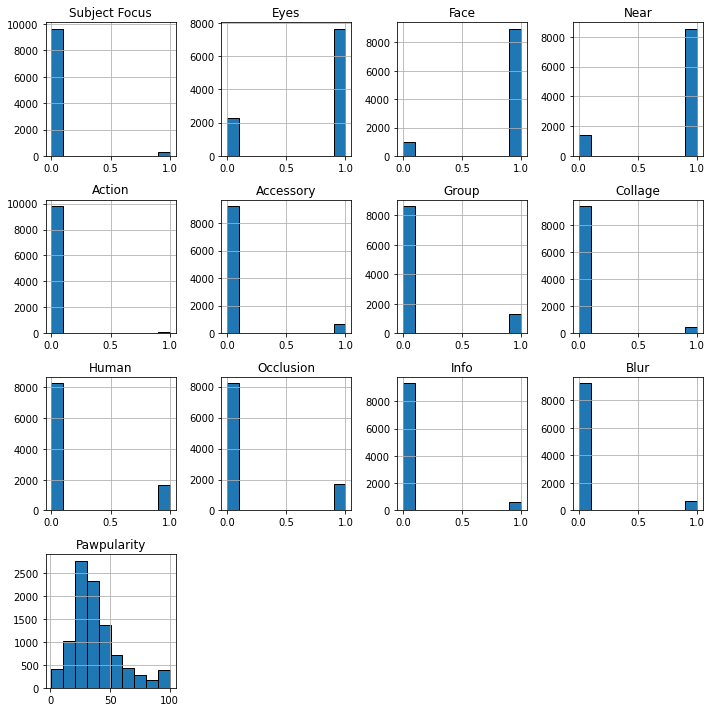

In [6]:
#Visualizing the spread??
train.hist(figsize=(10,10), ec="k")
plt.tight_layout()
plt.show()

In [7]:
#Mean of Pawpularity remove [] if you want the see mean on everything
print("Mean value of train "+ str(train['Pawpularity'].mean()))
train.info()

Mean value of train 38.03904358353511
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
 14  file_path      9912 non-null   object
dtypes: int64(13), object(2)
memory usage: 1.1+ MB


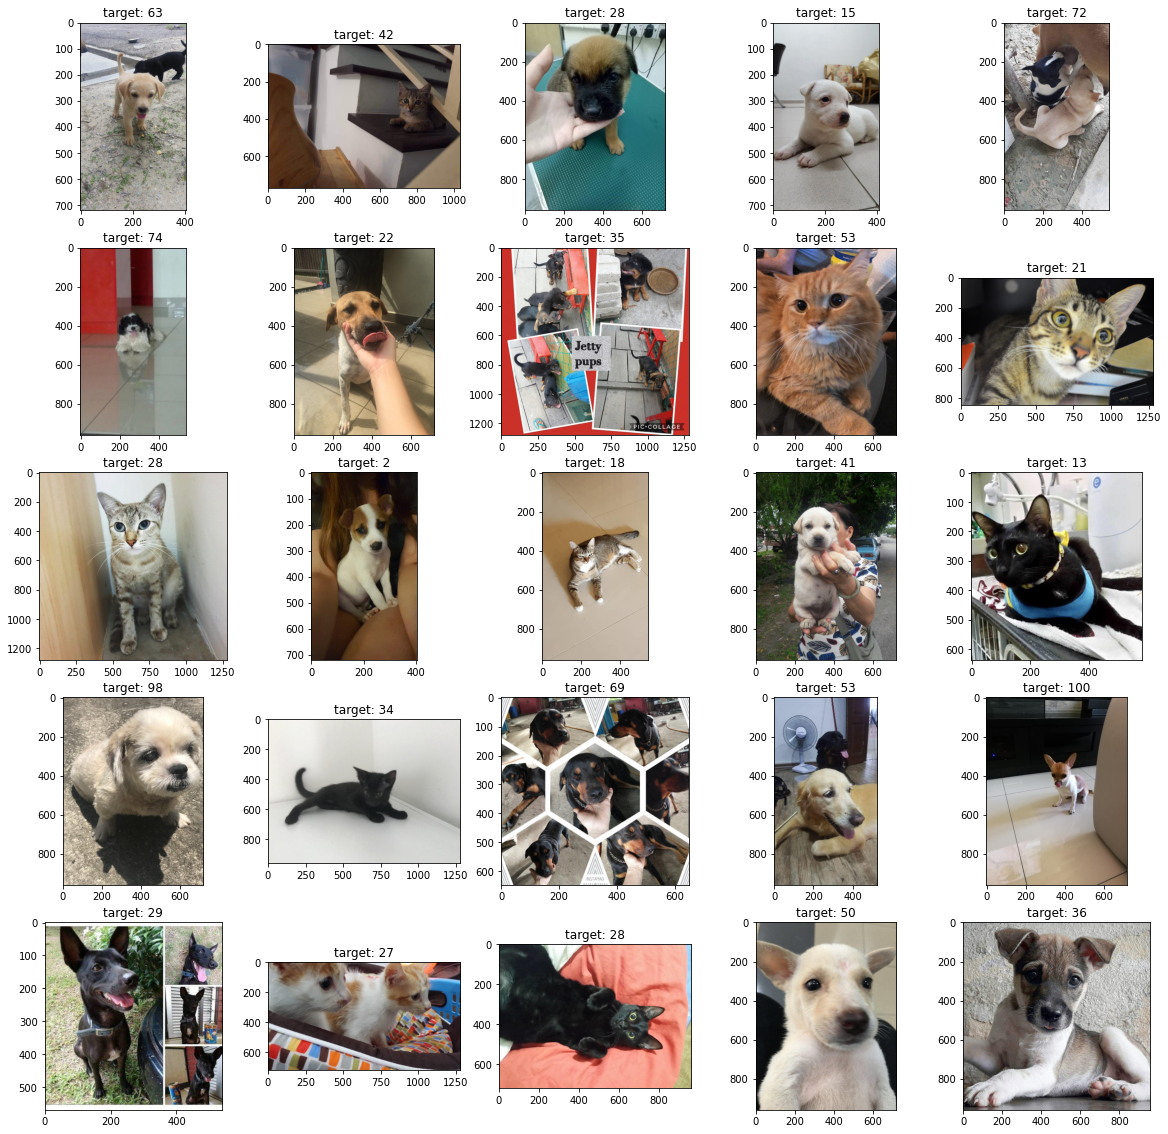

In [8]:
#Shows 5x5 images and their title is their paw score
plt.figure(figsize=(20, 20))
for i in range(5 * 5):
    plt.subplot(5, 5, i+1)
    image = plt.imread(train.loc[i, 'file_path'])
    #image = plt.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = train.loc[i, 'Pawpularity']
    plt.imshow(image)
    plt.title(f"target: {target}")
plt.show()

In [9]:
#ligner der er duplicates som skal fjernes 
#https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/278497 kode til at fjerne dem findes her
from tqdm.notebook import tqdm
tqdm.pandas()
def get_hash(file_path):
    img = Image.open(file_path)
    img_hash = imagehash.phash(img)
    
    return img_hash.hash.reshape(-1).astype(np.uint8)
    
train['phash'] = train['file_path'].progress_apply(get_hash)

  0%|          | 0/9912 [00:00<?, ?it/s]

  0%|          | 0/9912 [00:00<?, ?it/s]

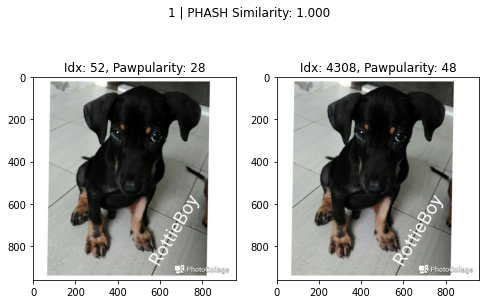

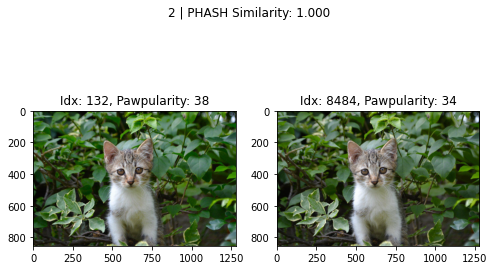

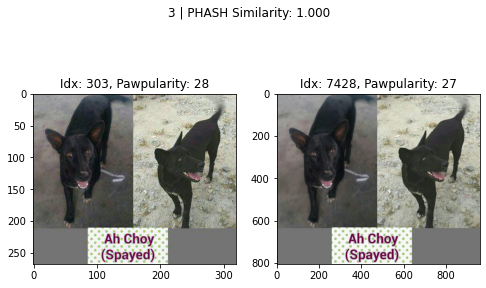

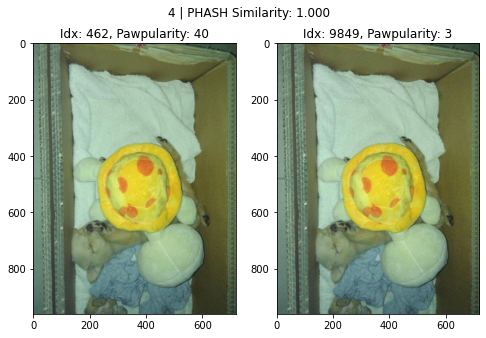

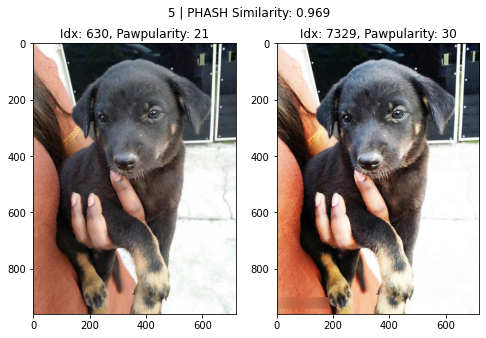

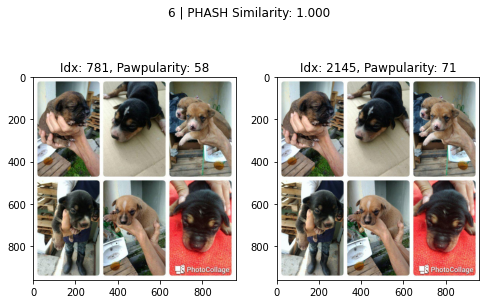

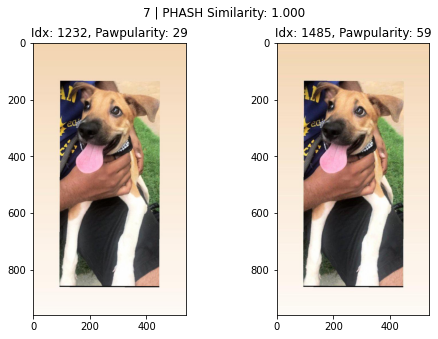

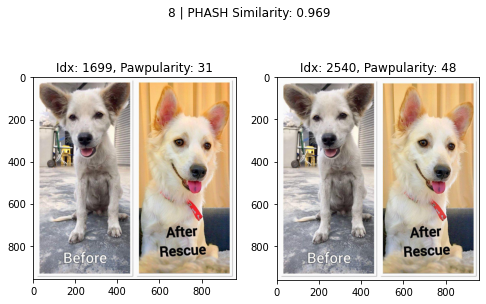

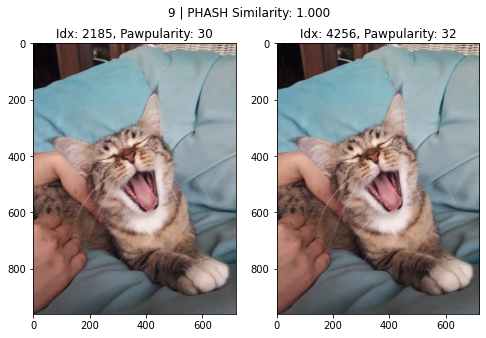

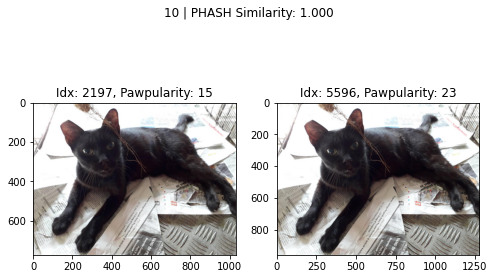

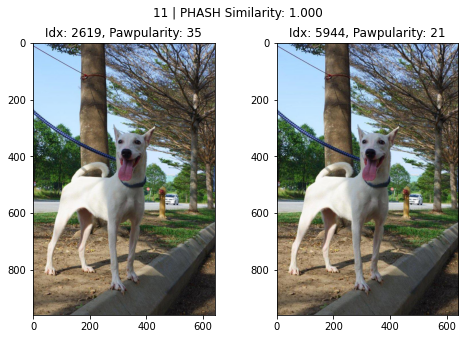

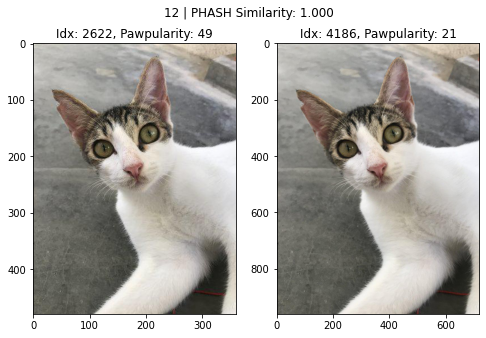

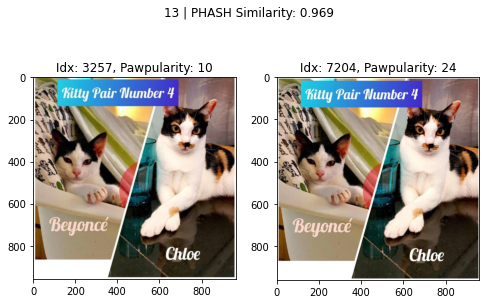

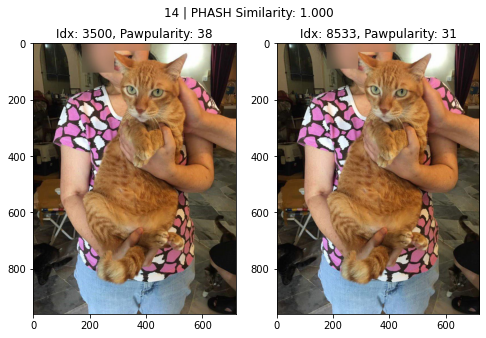

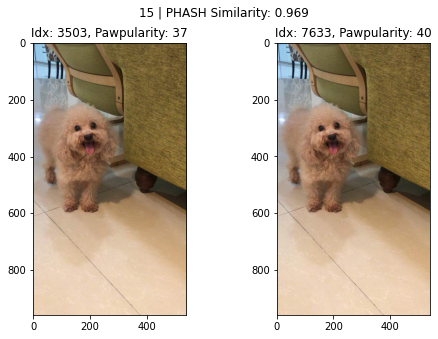

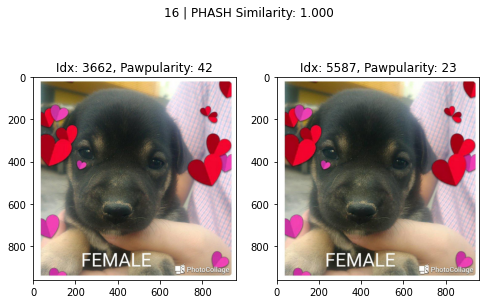

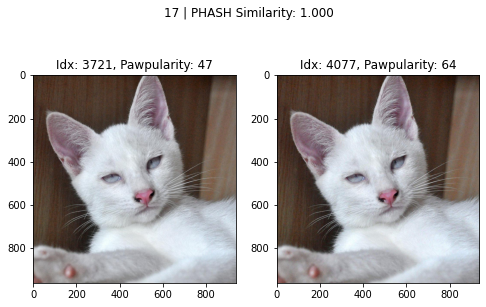

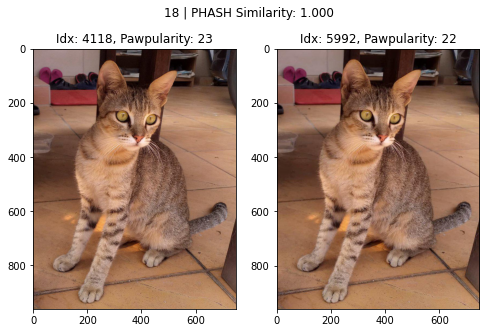

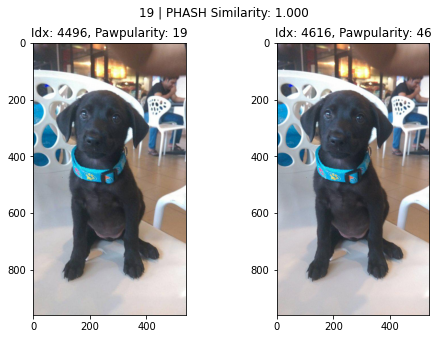

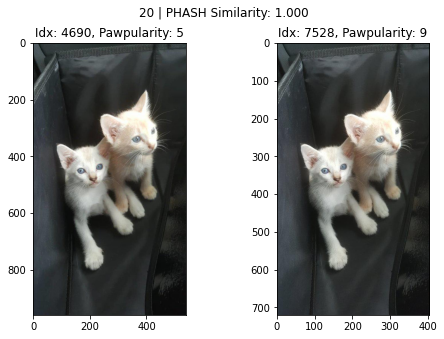

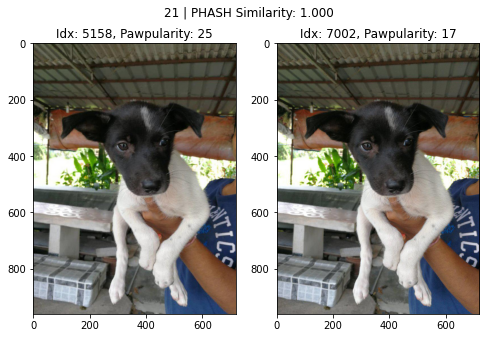

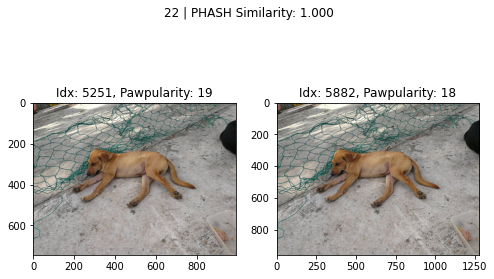

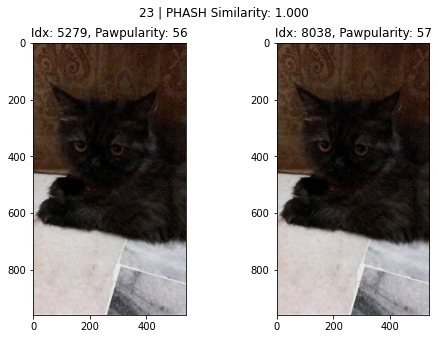

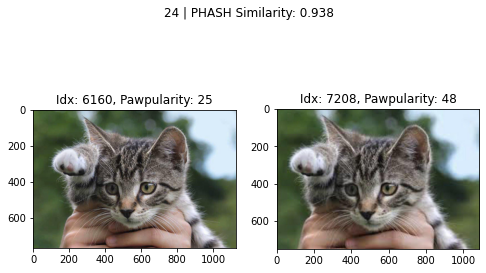

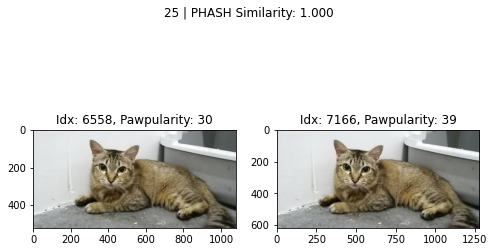

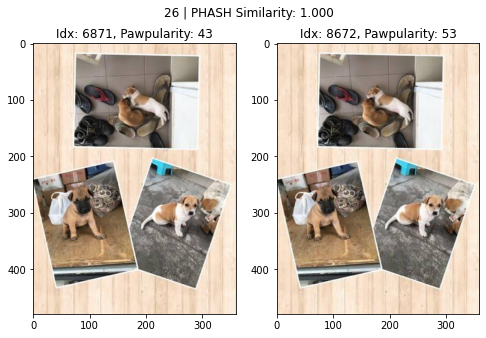

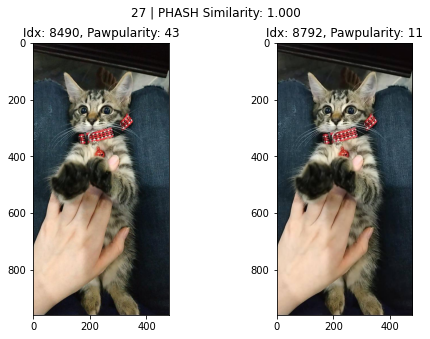

In [10]:
def find_similar_images(threshold=0.90):
    # Number of Duplicate Images Found
    duplicate_counter = 1
    # Indices of Duplicate Images
    duplicate_idxs = set()
    # For each image in the train dataset
    for idx, phash in enumerate(tqdm(train['phash'])):
        # Compute the similarity to all other images
        for idx_other, phash_other in enumerate(train['phash']):
            # Similarity score is imply the percentage of equal bits
            similarity = (phash ==phash_other).mean()
            # Prevent self comparison, threshold similarity and ignore repetetive duplicate detection
            if idx != idx_other and similarity > threshold and not(duplicate_idxs.intersection([idx, idx_other])):
                # Update Duplicate Indices
                duplicate_idxs.update([idx, idx_other])
                # Get DataFrame rows
                row = train.loc[idx]
                row_other = train.loc[idx_other]
                # Plot Duplicate Images
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
                ax[0].imshow(imageio.imread(row['file_path']))
                ax[0].set_title(f'Idx: {idx}, Pawpularity: {row["Pawpularity"]}')
                ax[1].imshow(imageio.imread(row_other['file_path']))
                ax[1].set_title(f'Idx: {idx_other}, Pawpularity: {row_other["Pawpularity"]}')
                plt.suptitle(f'{duplicate_counter} | PHASH Similarity: {similarity:.3f}')
                plt.show()
                # Increase Duplicate Counter
                duplicate_counter += 1
                
    # Return Indices of Duplicates
    return duplicate_idxs
    
duplicate_idxs = find_similar_images()
#The same images don't have the same paw score. The majority's paw score's diffrence is around 10.
#But some got over double the score'

In [15]:
print(f'Found {len(duplicate_idxs)} Duplicate Images')
# Removing Duplicate Images, 
#Code taken from https://www.kaggle.com/markwijkhuizen/petfinder-eda-yolov5-obj-detection-tfrecords#Image-EDA
#IMPORTANT(I think so atleast)! If this code is run twice it will drop both images instead of just one of the duplicates
#Hhich image is correct one? They got diffrent scores
train = train.drop(duplicate_idxs).reset_index(drop=True)
print("Amount of tranning's data: " + str(len(train)))

Found 54 Duplicate Images


KeyError: '[9849] not found in axis'

In [17]:
#We need some more preproccsing and data normalization

Amount of tranning's data: 9804


In [123]:
#no need to take original image later
def augment(augmented):
    # We need to test with the diffrent type of augment to see if they hurt the acc. 
    # We should also take some of the fuctions we used in CNN
    augmented = tf.image.random_brightness(augmented, 0.05)
    augmented = tf.image.random_flip_left_right(augmented)
    augmented = tf.image.random_saturation(augmented, 0.95, 1)
    augmented = tf.image.random_contrast(augmented, 0.95, 1)
    augmented = tf.image.random_hue(augmented, 0.05)
    return augmented

def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

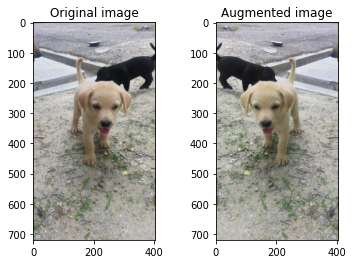

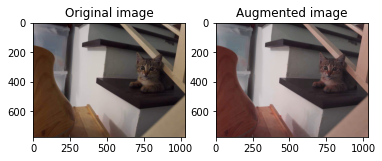

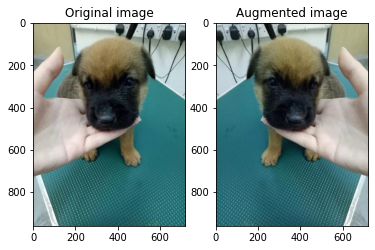

In [128]:
for i in range(3):
    image = plt.imread(train.loc[i, 'file_path'])
    changed_image = augment(image)
    visualize(image,changed_image)